In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.io import fits
from astropy.utils import data
from spectral_cube import SpectralCube
from astropy.wcs import WCS
from reproject import reproject_interp

In [34]:
data = fits.open('/home/patito/Documents/datoselectivo/cubo/jellifysh.fits')
cubo = SpectralCube.read(data[1])
data.close()

In [35]:
print(cubo)

SpectralCube with shape=(3682, 330, 328) and unit=1e-20 erg / (Angstrom s cm2):
 n_x:    328  type_x: RA---TAN  unit_x: deg    range:   354.092428 deg:  354.111908 deg
 n_y:    330  type_y: DEC--TAN  unit_y: deg    range:    21.141321 deg:   21.159599 deg
 n_s:   3682  type_s: AWAV      unit_s: Angstrom  range:     4750.401 Angstrom:    9351.651 Angstrom


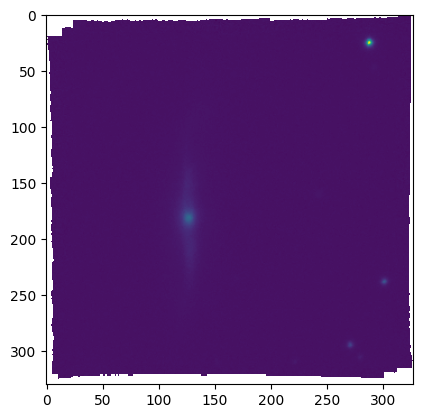

In [46]:
cubo[3500,:,:].quicklook()

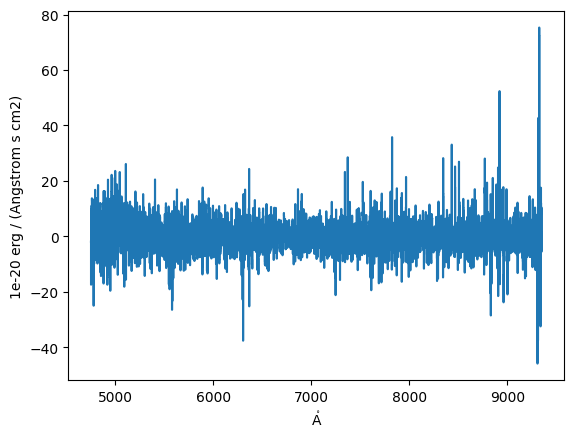

In [47]:
%matplotlib inline
cubo[:, 275, 290].quicklook() #extract a single spectrum through the data cube

In [48]:
#latitud y longitud de la imagen, se ponen las unidades en astropy
lat_range = [21.141321,21.159599] * u.deg 
lon_range = [354.092428,354.111908] * u.deg
#se genera el cubo con la informacion de ra dec
cubo = cubo.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1], zlo=5300*u.AA, zhi=5450*u.AA)

In [54]:
moment_0_stellarcontinuum = cubo.with_spectral_unit(u.AA).moment(order=0)  # Zero-th moment 
moment_1_oiii = cubo.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=5007*u.AA).moment(order=1)  # First moment

# Write the moments as a FITS image
moment_0_stellarcontinuum.write('oiii_moment_0.fits', overwrite=True) 
moment_1_oiii.write('oiii_moment_1.fits', overwrite=True)

print('Moment_0 has units of: ', moment_0_stellarcontinuum.unit)
print('Moment_1 has units of: ', moment_1_oiii.unit)

stellardensity = moment_0_stellarcontinuum * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  1e-20 erg / (s cm2)
Moment_1 has units of:  km / s


/home/patito/.local/lib/python3.10/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


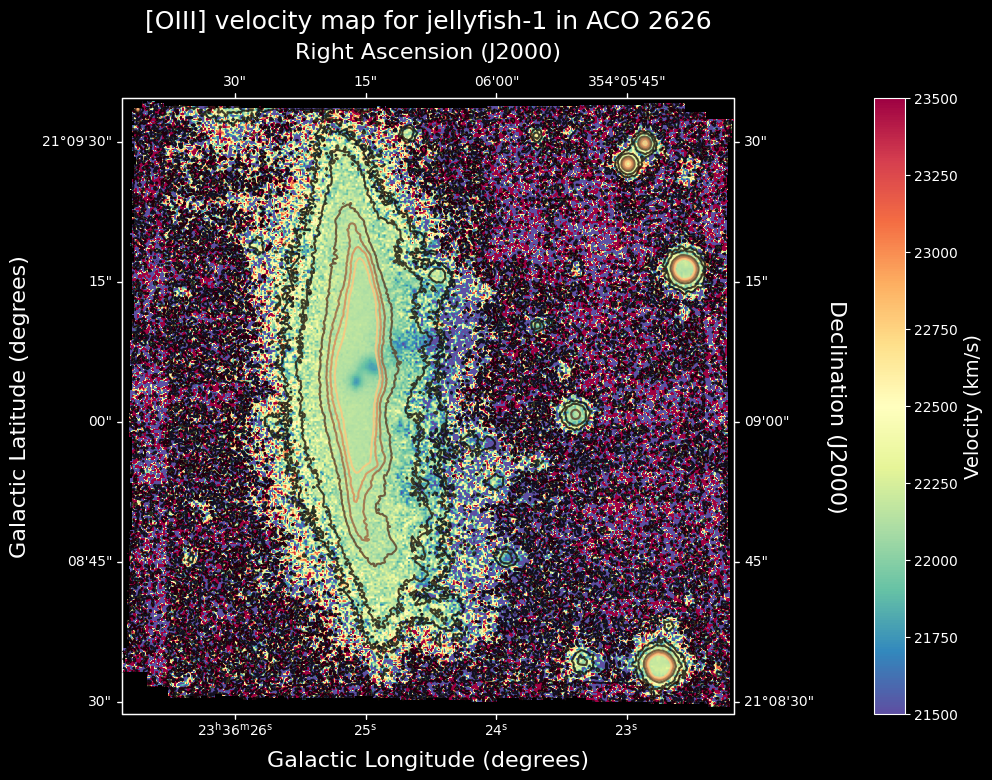

In [60]:
%matplotlib inline
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(12, 8),facecolor='black')
plt.style.use('dark_background')
ax = fig.add_subplot(111, projection=moment_1_oiii.wcs)

# Display the moment map image
im = ax.imshow(moment_1_oiii.hdu.data, cmap='Spectral_r', vmin=21500, vmax=23500)
#ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)


# Add a colorbar
cbar = plt.colorbar(im, pad=.15)
cbar.set_label('Velocity (km/s)', size=14)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
#overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours   # Define contour levels to use
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(stellardensity.hdu.data, cmap='copper', alpha=0.8, levels=levels)

plt.title('[OIII] velocity map for jellyfish-1 in ACO 2626', fontsize=18, color='white', y=1.1)
plt.show()